# Visualize Daily Weather Data
** Maintained cache of two-week radar data from 160 stations accross the US.**

In [13]:
import matplotlib
import warnings
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%matplotlib inline

### Query any station by location and time of the day

In [14]:
# example today's weather in the Bay Area
from datetime import datetime, timedelta
query = rs.query()
query.stations('KMUX').time(datetime.utcnow())

time=2016-03-05T07%3A12%3A13.649657&stn=KMUX

### Validate correctness of query.

In [15]:
rs.validate_query(query)

True

### Find data volume closest to queried time.

In [16]:
catalog = rs.get_catalog(query)
catalog.datasets

{'Level2_KMUX_20160305_0707.ar2v': <siphon.catalog.Dataset at 0x10e757210>}

### Load Data into a Dataset object

In [17]:
from siphon.cdmr import Dataset
ds = list(catalog.datasets.values())[0]
data = Dataset(ds.access_urls['CdmRemote'])

## Helper Functions

### Preprocess Raw Data: rescale, turn to float, and mask missing values

In [18]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

### Convert Polar to Cartesian

In [19]:
def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

### Retrieve variables needed for azimuth and range.

In [20]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

### Convert raw data to floats and the Polar coordinates to Cartesian.

In [21]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

### Import MetPy and obtain colortables for the NWS Reflectivity data.

In [66]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 10, 6)

### Plotting Helper Function

In [67]:
import matplotlib.pyplot as plt
import cartopy

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    
    return ax

### Plot current weather condition of the Bay Area, CA.

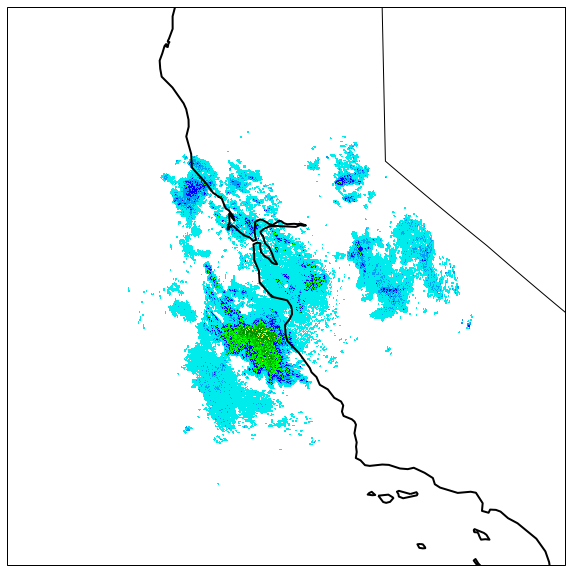

In [68]:
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0) #ref_cmap, plt.cm.rainbow

## Stitch Multiple Data Volumes to Make an Animation of the Clouds

In [83]:
query = rs.query()
#dt = datetime(2016, 3, 4, 12) # Our specified time
dt = datetime.utcnow()
# San Francisco -121.898, 37.155
#query.lonlat_point(-121.898, 37.155).time_range(dt, dt + timedelta(hours=2))
query.stations('KMUX').time_range(dt - timedelta(hours=3), dt)

time_start=2016-03-05T04%3A33%3A24.236801&time_end=2016-03-05T07%3A33%3A24.236801&stn=KMUX

### Collect all the datasets from the past 3 hours

In [85]:
cat = rs.get_catalog(query)
cat.datasets

{'Level2_KMUX_20160305_0434.ar2v': <siphon.catalog.Dataset at 0x152165750>,
 'Level2_KMUX_20160305_0438.ar2v': <siphon.catalog.Dataset at 0x152165810>,
 'Level2_KMUX_20160305_0442.ar2v': <siphon.catalog.Dataset at 0x1521658d0>,
 'Level2_KMUX_20160305_0445.ar2v': <siphon.catalog.Dataset at 0x152165d50>,
 'Level2_KMUX_20160305_0449.ar2v': <siphon.catalog.Dataset at 0x12104e850>,
 'Level2_KMUX_20160305_0453.ar2v': <siphon.catalog.Dataset at 0x152165b10>,
 'Level2_KMUX_20160305_0457.ar2v': <siphon.catalog.Dataset at 0x152165b90>,
 'Level2_KMUX_20160305_0500.ar2v': <siphon.catalog.Dataset at 0x152165e10>,
 'Level2_KMUX_20160305_0504.ar2v': <siphon.catalog.Dataset at 0x1218a9350>,
 'Level2_KMUX_20160305_0508.ar2v': <siphon.catalog.Dataset at 0x152165cd0>,
 'Level2_KMUX_20160305_0511.ar2v': <siphon.catalog.Dataset at 0x1521511d0>,
 'Level2_KMUX_20160305_0515.ar2v': <siphon.catalog.Dataset at 0x1521510d0>,
 'Level2_KMUX_20160305_0519.ar2v': <siphon.catalog.Dataset at 0x152165f50>,
 'Level2_KMU

### Let's make a nicer colored map, centered around the coordinates of the radar station

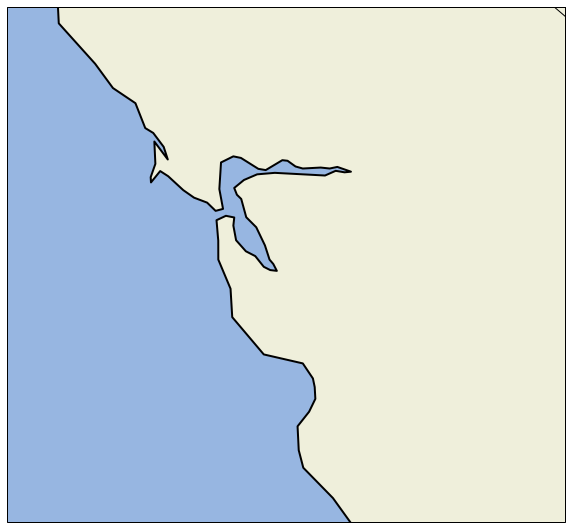

In [86]:
ds = list(cat.datasets.values())[0]
data = Dataset(ds.access_urls['CdmRemote'])
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set limits in lat/lon space -121.898, 37.155
ax.set_extent([-124, -120, 36, 39])

# Add ocean and land background
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale='50m',
                                            edgecolor='face',
                                            facecolor=cartopy.feature.COLORS['water'])
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='50m',
                                           edgecolor='face',
                                           facecolor=cartopy.feature.COLORS['land'])

ax.add_feature(ocean, zorder=-1)
ax.add_feature(land, zorder=-1)

### Extract plotting information for each Dataset to produce each frame

In [87]:
meshes = []
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    ds = item[1]
    data = Dataset(ds.access_urls['CdmRemote'])

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.65, 0.03, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

### Construct Animation of Weather Stream

In [88]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)